In [37]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal

In [38]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

In [39]:
input_dim = 28*28
latent_dim = 2
intermediate_dim = 256

In [40]:
inputs = layers.Input(shape=(input_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))   
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [42]:
encoder_inputs = layers.Input(shape=(input_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(encoder_inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [43]:
latent_inputs = layers.Input(shape=(latent_dim,))
h_decoded = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(input_dim, activation='sigmoid')(h_decoded)
decoder = Model(latent_inputs, outputs, name="decoder")

In [ ]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z) 
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.mse(inputs, reconstruction)
        ) * input_dim
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(reconstruction_loss + kl_loss)
        return reconstruction

vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

In [45]:
vae.fit(x_train, epochs=20, batch_size=128, validation_data=(x_test, None))
 
z_mean_train, _, _ = encoder.predict(x_train)
z_mean_test, _, _ = encoder.predict(x_test)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 54.2667 - val_loss: 45.1102
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 44.0584 - val_loss: 43.1370
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 42.9271 - val_loss: 42.4013
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 42.3332 - val_loss: 41.8451
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 41.8435 - val_loss: 41.3539
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 41.3931 - val_loss: 41.0053
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 41.0335 - val_loss: 40.6906
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 40.7345 - val_loss: 40.3918
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 40.4630 - val_loss: 40.2051
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 40.2443 - val_loss: 39.9824
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 40.0354 - val_loss: 39.8106
Epoch 12/20
469/469

In [47]:
classes = np.unique(y_train)
means = []
covariances = []

for c in classes:
    z_c = z_mean_train[y_train == c]
    mean_c = np.mean(z_c, axis=0)
    cov_c = np.cov(z_c, rowvar=False)
    means.append(mean_c)
    covariances.append(cov_c)
    print(f"Class {c}: mean={mean_c}, covariance=\n{cov_c}\n")

Class 0: mean=[0.3261949 1.9200367], covariance=
[[0.45290807 0.04287615]
 [0.04287615 0.52761104]]

Class 1: mean=[ 0.64632756 -1.9430968 ], covariance=
[[0.53507231 0.18402619]
 [0.18402619 0.22069771]]

Class 2: mean=[0.38213    0.19449893], covariance=
[[ 1.06401178 -0.42383911]
 [-0.42383911  0.32385084]]

Class 3: mean=[0.98987514 0.49803293], covariance=
[[0.40551813 0.12960453]
 [0.12960453 0.22303797]]

Class 4: mean=[-1.0245714  -0.05622223], covariance=
[[ 0.51412686 -0.19692915]
 [-0.19692915  0.16769469]]

Class 5: mean=[0.5904314  0.37816587], covariance=
[[0.5143287  0.25218152]
 [0.25218152 0.28523021]]

Class 6: mean=[-0.64325464  0.8380353 ], covariance=
[[ 0.44003167 -0.19357941]
 [-0.19357941  0.19384244]]

Class 7: mean=[-1.0709989 -0.8351244], covariance=
[[0.93145227 0.00198843]
 [0.00198843 0.23592887]]

Class 8: mean=[ 0.82524145 -0.04343042], covariance=
[[0.33452633 0.10378903]
 [0.10378903 0.19404135]]

Class 9: mean=[-1.0065248  -0.30640343], covariance=
[[

In [48]:
dist_matrix = cdist(means, means)
print("Pairwise Euclidean distances between class centroids:")
print(dist_matrix)

Pairwise Euclidean distances between class centroids:
[[0.         3.87637522 1.72644411 1.56925654 2.39377713 1.56434858
  1.45277646 3.08918484 2.02589498 2.59483667]
 [3.87637522 0.         2.15386064 2.4651854  2.52035689 2.32193552
  3.06556971 2.04372527 1.90807295 2.32608812]
 [1.72644411 2.15386064 0.         0.67932838 1.42887017 0.27771031
  1.21060014 1.7809289  0.50294943 1.47623349]
 [1.56925654 2.4651854  0.67932838 0.         2.0893046  0.41704127
  1.66814702 2.45448777 0.56593888 2.15237789]
 [2.39377713 2.52035689 1.42887017 2.0893046  0.         1.6724016
  0.97216202 0.7802846  1.84985709 0.25083124]
 [1.56434858 2.32193552 0.27771031 0.41704127 1.6724016  0.
  1.3166097  2.05728556 0.48257559 1.73749941]
 [1.45277646 3.06556971 1.21060014 1.66814702 0.97216202 1.3166097
  0.         1.72697088 1.7127354  1.20071028]
 [3.08918484 2.04372527 1.7809289  2.45448777 0.7802846  2.05728556
  1.72697088 0.         2.05487391 0.53263754]
 [2.02589498 1.90807295 0.50294943 0

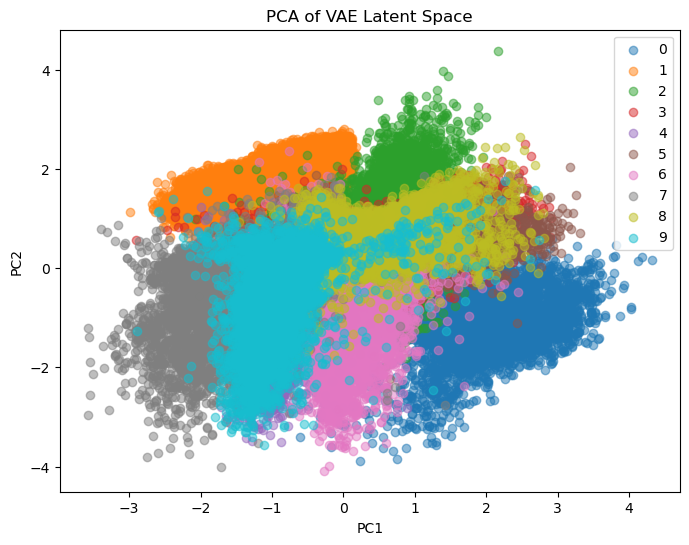

In [50]:
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_mean_train)
plt.figure(figsize=(8,6))
for c in classes:
    plt.scatter(z_pca[y_train==c,0], z_pca[y_train==c,1], label=str(c), alpha=0.5)
plt.title("PCA of VAE Latent Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

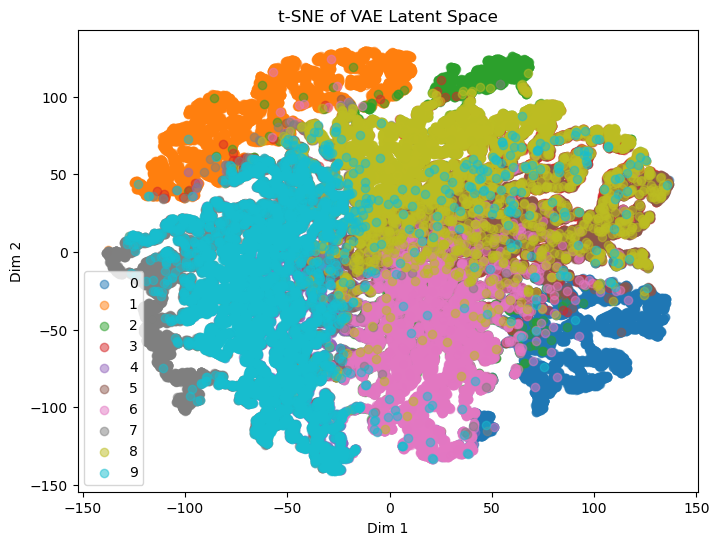

In [52]:
tsne = TSNE(n_components=2, random_state=42)
z_tsne = tsne.fit_transform(z_mean_train)
plt.figure(figsize=(8,6))
for c in classes:
    plt.scatter(z_tsne[y_train==c,0], z_tsne[y_train==c,1], label=str(c), alpha=0.5)
plt.title("t-SNE of VAE Latent Space")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend()
plt.show()

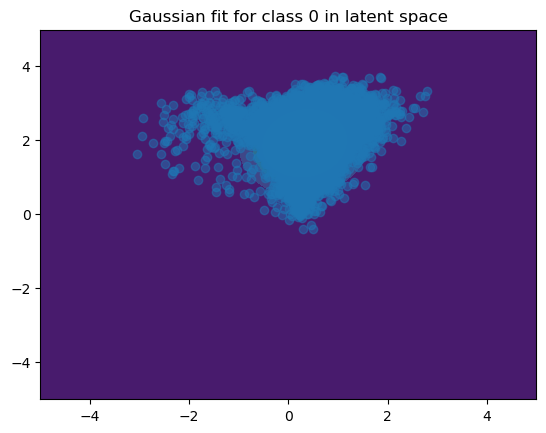

In [54]:
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(means[0], covariances[0])
plt.contourf(x, y, rv.pdf(pos))
plt.scatter(z_mean_train[y_train==0,0], z_mean_train[y_train==0,1], alpha=0.5)
plt.title("Gaussian fit for class 0 in latent space")
plt.show()

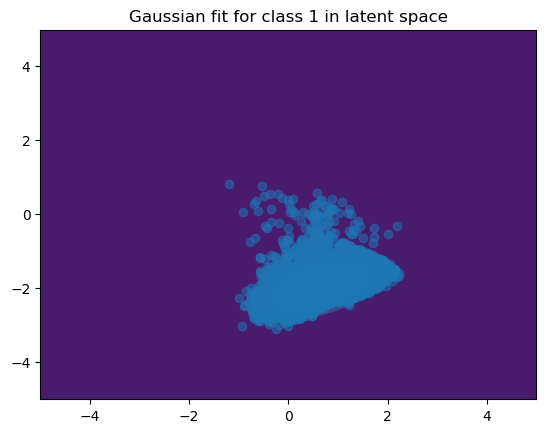

In [56]:
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(means[1], covariances[1])
plt.contourf(x, y, rv.pdf(pos))
plt.scatter(z_mean_train[y_train==1,0], z_mean_train[y_train==1,1], alpha=0.5)
plt.title("Gaussian fit for class 1 in latent space")
plt.show()

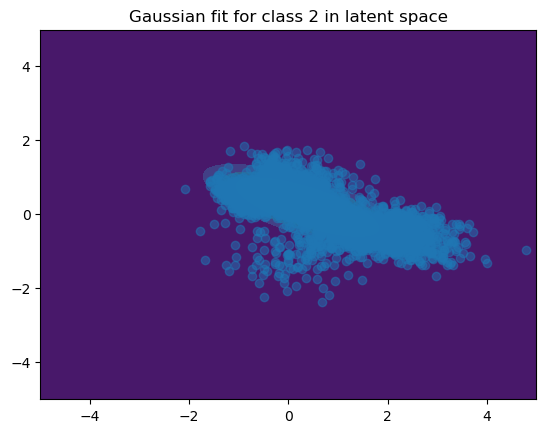

In [57]:
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(means[2], covariances[2])
plt.contourf(x, y, rv.pdf(pos))
plt.scatter(z_mean_train[y_train==2,0], z_mean_train[y_train==2,1], alpha=0.5)
plt.title("Gaussian fit for class 2 in latent space")
plt.show()

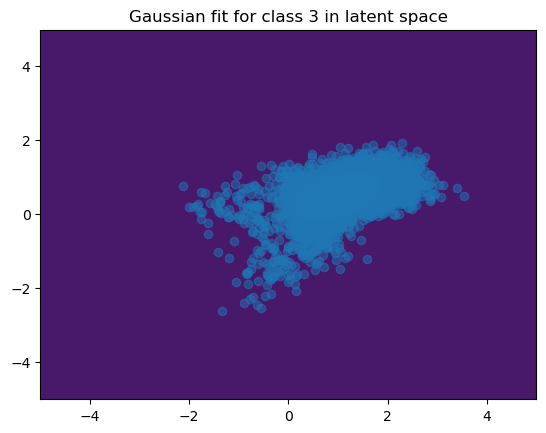

In [58]:
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(means[3], covariances[3])
plt.contourf(x, y, rv.pdf(pos))
plt.scatter(z_mean_train[y_train==3,0], z_mean_train[y_train==3,1], alpha=0.5)
plt.title("Gaussian fit for class 3 in latent space")
plt.show()

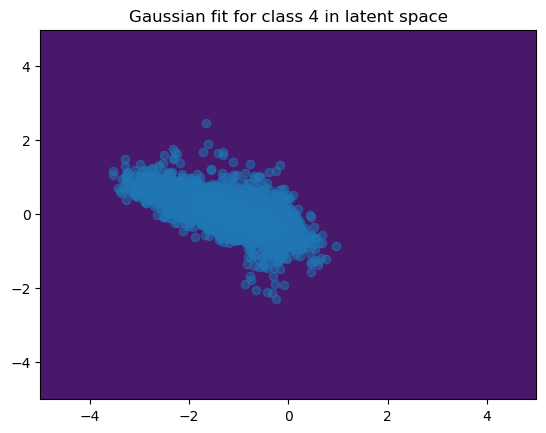

In [59]:
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(means[4], covariances[4])
plt.contourf(x, y, rv.pdf(pos))
plt.scatter(z_mean_train[y_train==4,0], z_mean_train[y_train==4,1], alpha=0.5)
plt.title("Gaussian fit for class 4 in latent space")
plt.show()

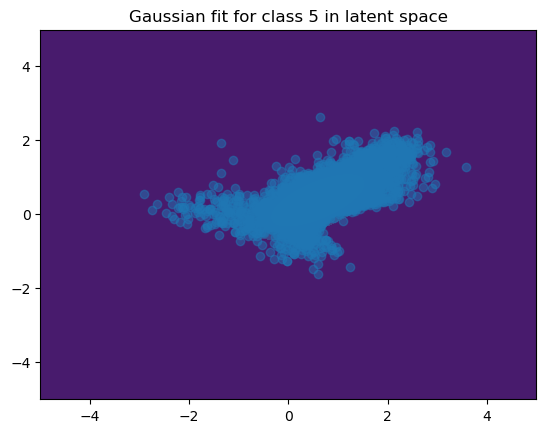

In [60]:
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(means[5], covariances[5])
plt.contourf(x, y, rv.pdf(pos))
plt.scatter(z_mean_train[y_train==5,0], z_mean_train[y_train==5,1], alpha=0.5)
plt.title("Gaussian fit for class 5 in latent space")
plt.show()

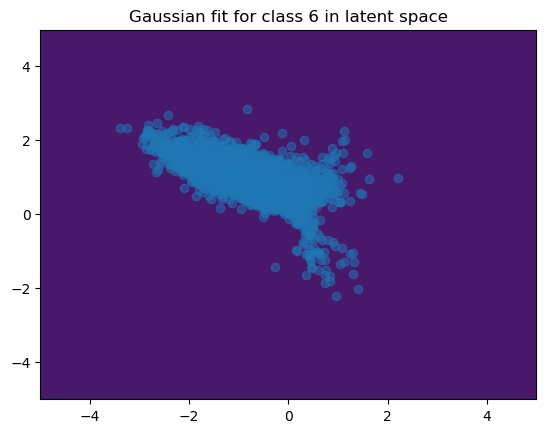

In [61]:
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(means[6], covariances[6])
plt.contourf(x, y, rv.pdf(pos))
plt.scatter(z_mean_train[y_train==6,0], z_mean_train[y_train==6,1], alpha=0.5)
plt.title("Gaussian fit for class 6 in latent space")
plt.show()

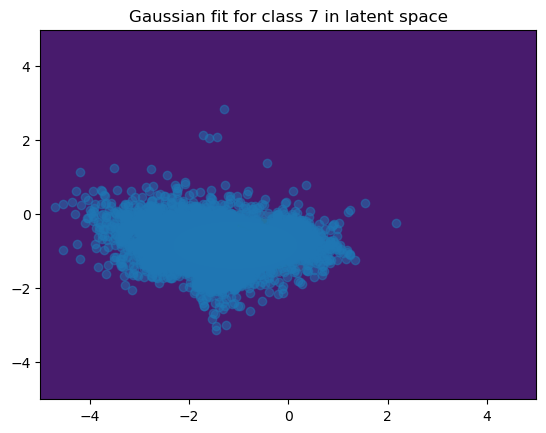

In [62]:
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(means[7], covariances[7])
plt.contourf(x, y, rv.pdf(pos))
plt.scatter(z_mean_train[y_train==7,0], z_mean_train[y_train==7,1], alpha=0.5)
plt.title("Gaussian fit for class 7 in latent space")
plt.show()

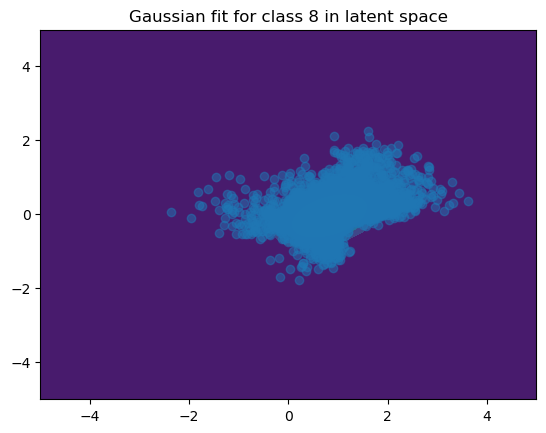

In [63]:
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(means[8], covariances[8])
plt.contourf(x, y, rv.pdf(pos))
plt.scatter(z_mean_train[y_train==8,0], z_mean_train[y_train==8,1], alpha=0.5)
plt.title("Gaussian fit for class 8 in latent space")
plt.show()

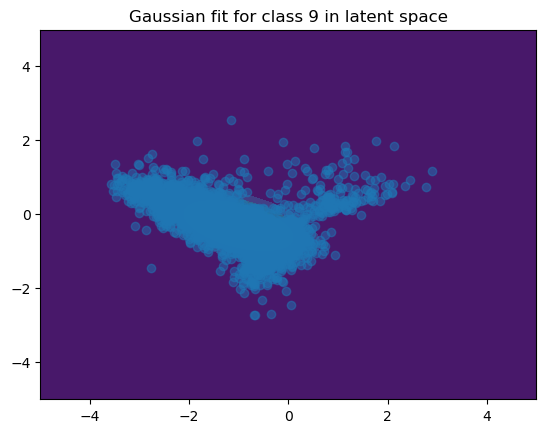

In [64]:
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(means[9], covariances[9])
plt.contourf(x, y, rv.pdf(pos))
plt.scatter(z_mean_train[y_train==9,0], z_mean_train[y_train==9,1], alpha=0.5)
plt.title("Gaussian fit for class 9 in latent space")
plt.show()